<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/FtStewartGopherTortious.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gopher Tortoise Restoration

#### This notebook demonstrates how Raster Tools and ancillary data can be used to identify Gopher Tortoise Restoration locations. Datasets used in this notebook include raster surfaces created in [Hogland et al. 2020](https://www.mdpi.com/1999-4907/11/4/426).

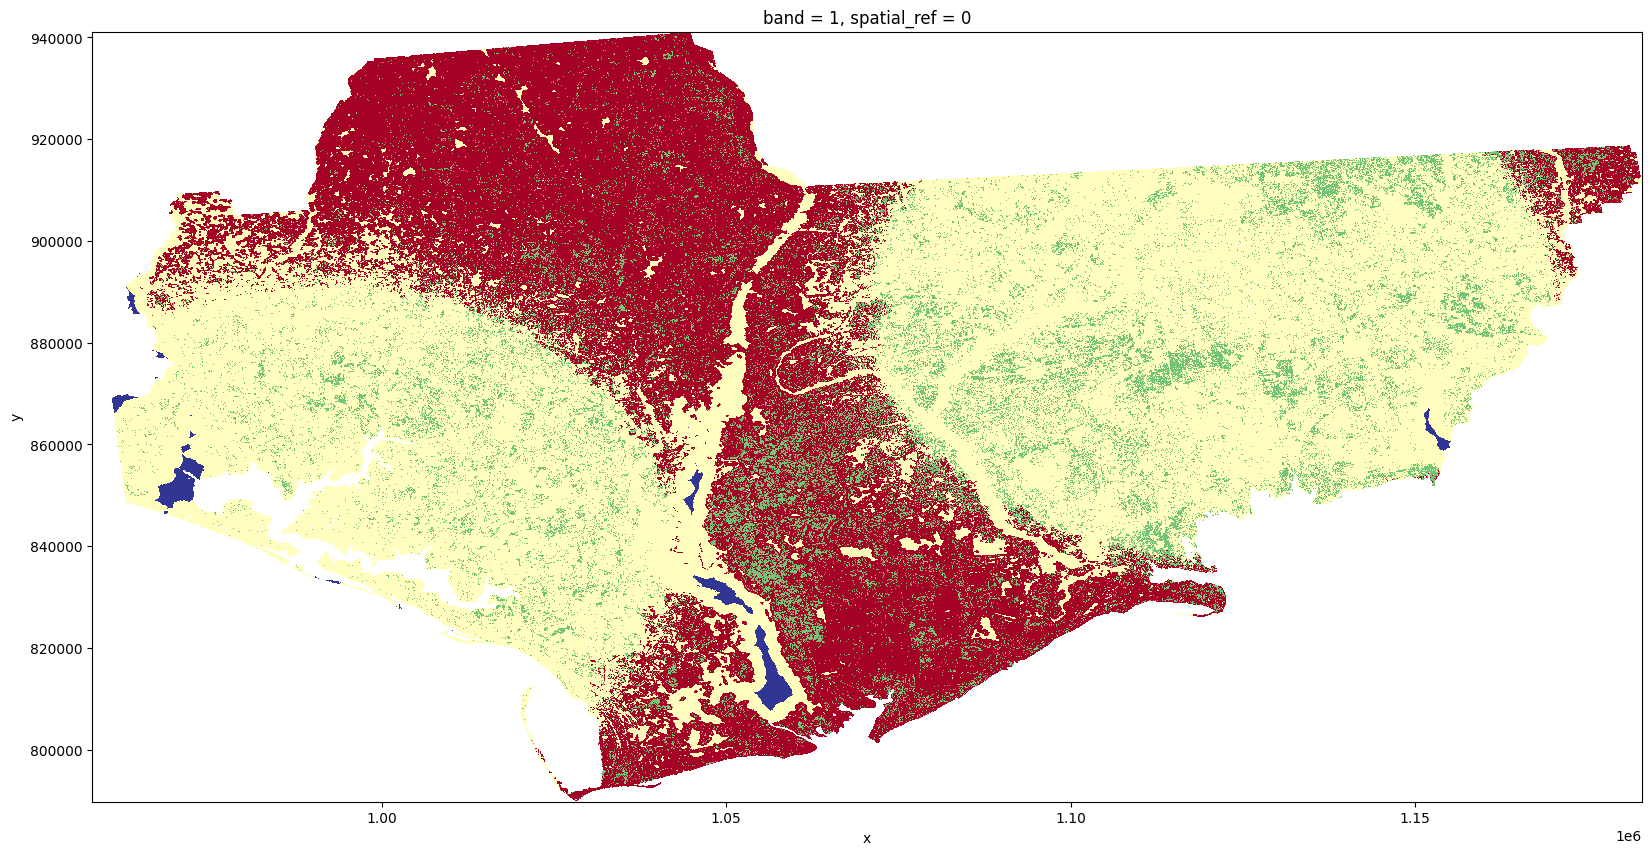

### Dataset can be manually downloaded from [ANF 2020 data outputs](https://drive.google.com/file/d/1zdiNMH0fopnkvZ2HmnI2ZaP1zIUB68VR/view?usp=sharing).
  
#### Author: John Hogland 5/22/2023

## Overview
#### Modeled estimates of needle and broad leaf basal area (ft<sup>2</sup> acre<sup>-1</sup>) and stem counts (acre <sup>-1</sup>) derived in [Hogland et al. 2020](https://www.mdpi.com/1999-4907/11/4/426) will be used to define potential longleaf Gopher Tortoise restoration units within the Appalachia National Forest (ANF) significant geographic area (SGA). To help navigate these steps the notebook has been split into five sections:
1. Installing software
2. Downloading the data
3. Identifying potential restoration stands
4. Visualizing the results

### Install software
#### This step is meant to install Raster Tools and upgrade various packages on [Google's Colab](https://colab.research.google.com/). If working locally and raster tools has already been installed, this step can be skipped.

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install raster_tools
!pip install osmnx

### Download the data
#### To download the data for this notebook run the cell below. After downloading the data and extracting the zipped contents you will have a ".\GopherTortoiseCaseStudy" directory containing each of the raster surfaces created within the [Hogland et al. 2020](https://www.mdpi.com/1999-4907/11/4/426) study.

#### Files we will be using in this notebook include:
- oBAA = other basal area (ft<sup>2</sup> acre<sup>-1</sup>)
- pBAA = pine basal area (ft<sup>2</sup> acre<sup>-1</sup>)
- oTPA = other stems (ha<sup>-1</sup>)
- pTPA = pine stems (ha<sup>-1</sup>)
- ANFSGA = boundary of study area

In [ ]:
import gdown, zipfile, os

url=r'https://drive.google.com/file/d/1e1WT2TCE3OSB4nLxUXxV8FcHUKJtUjF9/view?usp=sharing'
outfl = r"./GopherTortoise.zip"
if (not os.path.exists(outfl)):
  gdown.download(url=url, output=outfl, quiet=False, fuzzy=True)

  with zipfile.ZipFile(outfl, "r") as zip_ref:
      zip_ref.extractall(".")

#### Let's visualize the boundary and the pine bah raster surfaces using [Folium](https://python-visualization.github.io/folium/)

In [ ]:
from raster_tools import open_vectors, Raster
import folium

# Specify the path of the raster datasets
path_pbah = "./GopherTortoiseCaseStudy/pBAH.tif"
path_sga = "./GopherTortoiseCaseStudy/AnfSGA.shp"
pbah=Raster(path_pbah).remap_range((150,100000000,150)) #remap large values to 150 for visualization

# Load SGA shape file
geoDf=open_vectors(path_sga).data.compute()


# Create folium map, add tile layer, and display
m=geoDf.explore(name='ANF SGA',color='orange',style_kwds={"fillOpacity":0})

folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Imagery",
    overlay=False,
    control=True,
).add_to(m)

m=pbah.explore(band=1,cmap='viridis',map=m,name='Pine BAH')

m

### Identifying potential restoration stands (**Table 1**). Stands or contiguous regions that are in need of restoration have both a pine and other tree species basal area components that if treated would provide potential habitat for Gopher tortoise.
#### Steps
1. Read in data, address null values.
2. Create environmental *f*(E) and management *f*(M) metrics.
3. Normalize *f*(E) and *f*(M) metrics to a value between 0-100; E<sub>s</sub>, M<sub>s</sub> respectively.
4. Weight and combine normalized metrics to create a raster Gopher tortoise restoration prioritization surface
5. Visualize the results


<h4 style="text-align: center;">
    <b>Table 1.</b> Modeling procedure and Criteria used to identify restoration stands.
</h4>
   
|Model|Surface|Criteria|
|:-:|:-:|:-:|
|1|Pine BAH|$$ pBAH[band 1] < 15 $$|
|2|Other BAH|$$ oBAH[band 1] < 8 $$|
|3|TPH|$$ (pTPH[band 1] + oTPH[band 1]) < 800 $$|
|4|DFT|$$ DFT[band 3] > 0.5 $$|
|5|Habitat|$$ (model 1 + model 2 + model 3 + model 4) = 4 $$|
|6|Cost|$$ DFT[band 1] + DFT[band 2] + 0.01 $$|
|7|*f*(E)|cost distance from habitat (source=model5, cost=model6)|
|8|distance to roads|*euclidean distance from roads (m)*|
|9|distance to cities|*euclidean distance from cities (m)*|
|10|*f*(M)|$$ \frac{model 8 + model 9}{2}\ $$|
|11|E<sub>s</sub>|$$ \biggl(1-\biggl(\frac{model 7 - min(model 7)}{max(model 7) - min(model 7)}\biggr)\biggr) * 100 $$|
|12|M<sub>s</sub>|$$ \frac{model 10 - min(model 10)}{max(model 10) - min(model 10)}\ * 100 $$|
|13|Restoration|$$ 0.66 * model 11 + 0.34 * model 12 $$ |


#### Step 1: Read in data and address null values

In [ ]:
from raster_tools import Vector, distance
import numpy as np

#read in the dft, bah, and tph data and set null values to 0
pbah=Raster(path_pbah)

obah=Raster(path_obah)

ptph=Raster(path_ptph)

otph=Raster(path_otph)

dft=Raster(path_dft)

##### Get road and city data from Open Street Map

In [ ]:
import osmnx as ox

# create a definition to donwload data from OSM using a bounding box
def get_osm_data(sgeo,osm_dic={'highway':['motorway','trunk','primary','secondary','tertiary','unclassified','residential']},out_crs=None):
    '''
    downloads openstreetmaps data for a specified dictionary of layers and returns a geopandas dataframe

    sgeo: object, polygon bounding box used to extract data (WGS 84 - EPSG:4326)
    osm_dic: dictionary, dictionary of data types and resources
    out_crs: object, optional crs used to project geopandas dataframe to a differnt crs

    return: geopandas dataframe
    '''
    out_gdf=ox.geometries_from_polygon(sgeo,osm_dic)
    if(not out_crs is None):
        out_gdf=out_gdf.to_crs(out_crs)
    return out_gdf

wgs_gdf=geoDf.to_crs('EPSG:4326')
ply=wgs_gdf.geometry[0]
rgdf=get_osm_data(ply,out_crs=pbah.crs)
cgdf=get_osm_data(ply,{'place':['city']},out_crs=pbah.crs)
roads_gdf=Vector(rgdf.reset_index())
cities_gdf=Vector((cgdf[cgdf.geometry.type == 'Point']).reset_index())

##### Step 2. Spatial analyses

In [ ]:
%%time

#Calculate f(E) model steps 1-7
model1=(pbah.get_bands([1])<15).astype('int32')
model2=(obah.get_bands([1]) < 8).astype('int32')
model3=((ptph.get_bands([1]) + otph.get_bands([1])) < 800).astype('int32')
model4=(dft.get_bands([3])>0.5).astype('int32')
model5=((model1+model2+model3+model4) == 4).astype('int32').set_null_value(0)
model6=dft.get_bands([1])+dft.get_bands([2])+0.01
model7=distance.cda_cost_distance(model6,model5,None).set_null_value(model6.null_value)

#Calculate f(M) model steps 8-10
model8=distance.pa_proximity(roads_gdf.to_raster(like=pbah))
model9=distance.pa_proximity(cities_gdf.to_raster(like=pbah))
model10= (model8 + model9) / 2


##### Step 3. Normalize _f_(E) and _f_(M)

In [ ]:
#Calculate restoration priorties
s7=model7.min().compute()
m7=model7.max().compute()
s10=model10.min().compute()
m10=model10.max().compute()
model11=(1-((model7-s7)/(m7-s7)))*100
model12=((model10-s10)/(m10-s10))*100

##### Step 4. Weight and combine E<sub>s</sub> and M<sub>s</sub> metrics

In [ ]:
model13= (0.66*model11) + (0.34*model12)

##### Step 5. Visualize the results

In [ ]:
# Save model13 raster (gopher tortoise restoration)
outname='potential_restoration_sites.tif'
model13.save(outname)

In [ ]:
# Create a TileClient from a raster file
client1 = TileClient(outname)

# Create ipyleaflet TileLayer from that server
t1 = get_folium_tile_layer(client1, band=[1], name="Potenital Restoration Sites",overlay=True, vmin=40,vmax=75,palette='viridis',nodata=0,show=True,opacity=0.8)



# Create folium map, add tile layer, and display
m=geoDf.explore(name='ANF SGA',color='orange',style_kwds={"fillOpacity":0})

folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Imagery",
    overlay=False,
    control=True,
).add_to(m)

m.add_child(t1)

# add layer controls to the map
folium.LayerControl().add_to(m)
m

##### Remap priority values to high (value >= 75), medium (50 <= value < 75), and low (value < 50) categories and summarize.

In [ ]:
gtp=Raster(outname)
r_gtp=gtp.remap_range(([0,50,1],[50,75,2],[75,150,3]))

In [ ]:
from matplotlib import pyplot as plt

fig,ax=plt.subplots(figsize=(20,10))
r_gtp.plot(ax=ax,cmap='RdYlBu_r',add_colorbar=False)
model5.plot(ax=ax,cmap='Greens',add_colorbar=False)
plt.show()


In [ ]:
from raster_tools import zonal
tbl=zonal.zonal_stats(r_gtp.astype('int32'),gtp,['mean','size']).compute()
area=tbl[[('band_1','size')]]

In [ ]:
hab=model5.sum().compute()
area.loc[len(area.index)+1] = [hab]
area['Priority']=['Low','Medium','High','Habitat']
area['ha']=area[[('band_1','size')]]*900/10000
area.plot(x='Priority',y='ha',kind='bar')

# This ends the Longleaf Gopher Tortoise Restoration notebook
## Check out the other notebooks:
- https://github.com/UM-RMRS/raster_tools/blob/main/notebooks/README.md
## References
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html